# Introduction

In this notebook we load and analyze two velocity datasets derived from DART impact simulations on the Didymos–Dimorphos binary system. Each dataset contains 1000 velocity samples for a single simulated particle: one dataset corresponds to a particle that escapes the binary system after the impact, while the other corresponds to a particle that remains inside the system (due to impact on Didymos or Dimorphos, or by being placed on an unstable orbit). The raw files are located in the `data/raw/` folder.

Objective
- Identify whether there are clear turning points or threshold regions in the velocity distributions that separate escape from retention.
- Build machine learning models capable of mapping the probability of escape as a function of velocity features and to estimate critical velocity ranges where the transition occurs.

Analysis workflow
- Data loading and validation: read CSV files, check for missing or inconsistent values, and verify units.
- Exploratory data analysis (EDA): histograms, kernel density estimates, scatter plots, and comparison of distributions between the two groups.
- Feature engineering: compute scalar speed, velocity components, and any transformations that improve separability for modeling.
- Machine learning modeling: train interpretable classifiers (e.g., logistic regression) and non-linear models (e.g., Random Forest) to predict escape vs retention.
- Turning point detection: analyze model decision functions and probability curves, and compute derivatives of the escape probability with respect to velocity to estimate threshold regions.
- Validation and interpretation: use cross-validation and metrics (accuracy, ROC-AUC, precision/recall), and apply feature-importance methods (e.g., permutation importance or SHAP) to interpret results.

Practical notes
- Subsequent cells provide code to load the files from `data/raw/`, produce EDA figures, train models with cross-validation, and save key outputs to `results/`.
- Save important figures, models, and tables to the `results/` folder for later reference and inclusion in the thesis.

In [55]:
import numpy as np
import pandas as pd

#Load data from raw folder
path = "../data/raw"
def load_datasets():
    df1 = pd.read_csv(f"{path}/2nd_simulation_escaped.csv")
    df2 = pd.read_csv(f"{path}/2nd_simulation_survived.csv")
    return df1, df2

#Check for missing or inconsistent data
def check_data_quality(df):
    print("Missing values per column:")
    print(df.isnull().sum())
    print("\nData types:")
    print(df.dtypes)

#Use the function to load datasets
df_escaped, df_survived = load_datasets()
#check_data_quality(df_escaped)
#check_data_quality(df_survived)


#### Exploratory Data Analysis

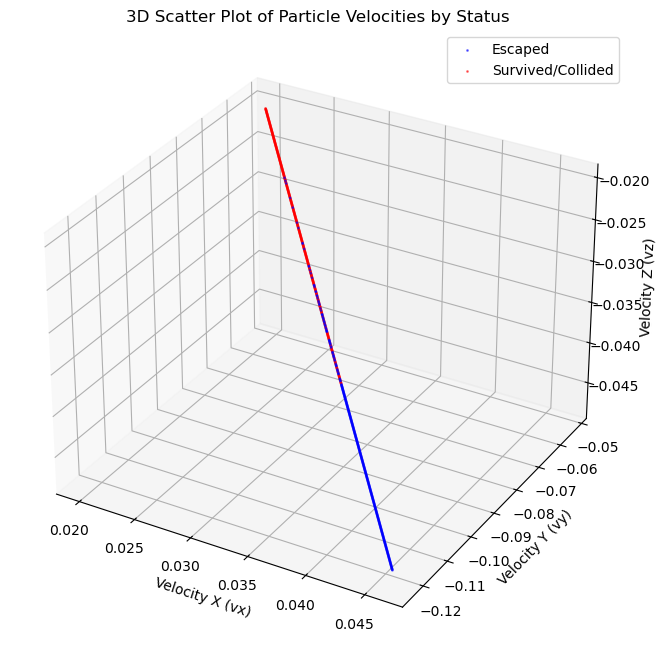

In [57]:
#Plot for exploratory data analysis
import matplotlib.pyplot as plt
import seaborn as sns

def plot_3d_velocity_status(df):
    #Select columns for 3D plot
    x = df['vx']
    y = df['vy']
    z = df['vz']
    status = df['st'] 

    #Define color mask based on status
    #st=1 escaped in blue, st!=1 survived/collided in red
    is_escaped = (status == 1)

    #Create 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    #Scatter plot for escaped particles, s = size of points, alpha = transparency
    ax.scatter(x[is_escaped], y[is_escaped], z[is_escaped], c='blue', label='Escaped', alpha=0.5, s=1)
    #Scatter plot for survived/collided particles
    ax.scatter(x[~is_escaped], y[~is_escaped], z[~is_escaped], c='red', label='Survived/Collided', alpha=0.5, s=1)

    #Set labels and title
    ax.set_xlabel('Velocity X (vx)')
    ax.set_ylabel('Velocity Y (vy)')
    ax.set_zlabel('Velocity Z (vz)')
    ax.set_title('3D Scatter Plot of Particle Velocities by Status')
    ax.legend()
    plt.show()

    #Save the plot
    fig.savefig("../results/plots/2nd_dataset/3D_velocity_status.png", dpi=300)

#Use the function to plot data
plot_3d_velocity_status(df_escaped)


It is possible to observe that particles with higher velocity values tend to escape, while those with lower velocity values are more likely to survive or collide. The separation is not perfectly clear-cut, indicating that other factors may also influence the fate of the particles. It is also possible to plot the velocity magnitude (speed) against the status (since the velocity is monodirectional, the plot will look similar to the 3d plot) to condensate the information.

#### 1D Graphic Analysis
The goal is to visualize how the status st of the particle changes with respect to the velocity module (speed), keeping separated the two datasets in order to see if there are differences in the distributions.

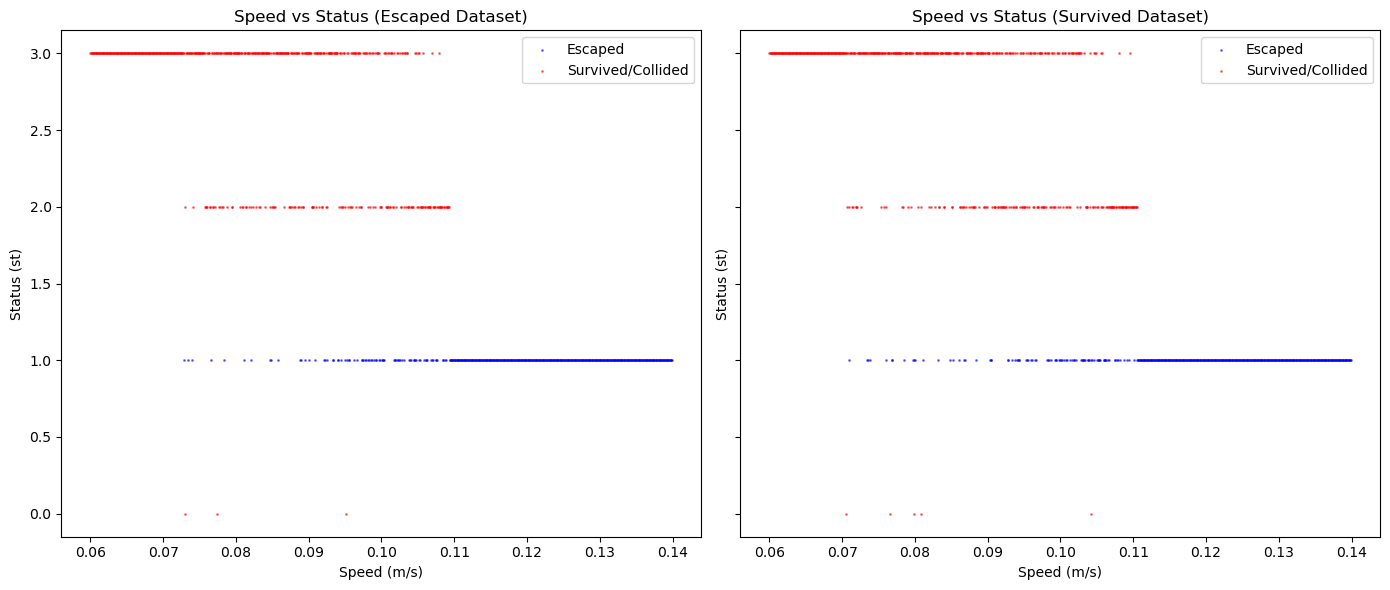

In [59]:
#Compute the magnitude of velocity (speed)
def compute_speed(df):
    return np.sqrt(df['vx']**2 + df['vy']**2 + df['vz']**2)

df_escaped['v_mag'] = compute_speed(df_escaped)
df_survived['v_mag'] = compute_speed(df_survived)

#Plot (2 different datasets) speed vs status
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

#Helper function to plot speed vs status
def plot_particle(ax, df, title):
    #Escape particles in blue (st=1)
    escaped = df[df['st'] == 1]
    ax.scatter(escaped['v_mag'], escaped['st'], c='blue', label='Escaped', alpha=0.5, s=1)
    #Non-escaped particles in red (st!=1)
    non_escaped = df[df['st'] != 1]
    ax.scatter(non_escaped['v_mag'], non_escaped['st'], c='red', label='Survived/Collided', alpha=0.5, s=1)
    
    #Set labels and title
    ax.set_xlabel('Speed (m/s)')
    ax.set_ylabel('Status (st)')
    ax.set_title(title)
    ax.legend()

#Plot for escaped dataset
plot_particle(ax1, df_escaped, 'Speed vs Status (Escaped Dataset)')
#Plot for survived dataset 
plot_particle(ax2, df_survived, 'Speed vs Status (Survived Dataset)')  
fig.savefig("../results/plots/2nd_dataset/speed_vs_status.png", dpi=300)

plt.tight_layout()
plt.show()

For a 1D problem like this, where we are looking for a threshold speed to classify particles, complex models like random forest or XGboost may be unnecessary. A simple linear model or logistic regression could suffice to find a decision boundary based on speed alone. We will try two different models: support vector machine (SVM) and logistic regression.

The first step is preparing the data set and split it into training and test set.

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Compute velocity module
df_escaped['v_mag'] = compute_speed(df_escaped)
df_survived['v_mag'] = compute_speed(df_survived)

# Per il dataset derivato dalla particella "Escaped"
df_escaped['target'] = np.where(df_escaped['st'] == 1, 1, -1)

# Per il dataset derivato dalla particella "Survived"
df_survived['target'] = np.where(df_survived['st'] == 1, 1, -1)

#Save the new dataframe in ../processed folder
df_escaped.to_csv("../data/processed/escaped_with_speed.csv", index=False)
df_survived.to_csv("../data/processed/survived_with_speed.csv", index=False)

#Load the dataframe
df_escaped = pd.read_csv("../data/processed/escaped_with_speed.csv")
df_survived = pd.read_csv("../data/processed/survived_with_speed.csv")

#Split 80/20
X_escaped = df_escaped[['v_mag']]
y_escaped = df_escaped['target']
X_survived = df_survived[['v_mag']]
y_survived = df_survived['target']

#Divide training and testing set (80/20) with stratification
X_escaped_train, X_escaped_test, y_escaped_train, y_escaped_test = train_test_split(
    X_escaped, y_escaped, test_size=0.2, random_state=42, stratify=y_escaped)
X_survived_train, X_survived_test, y_survived_train, y_survived_test = train_test_split(
    X_survived, y_survived, test_size=0.2, random_state=42, stratify=y_survived)

#Initialize the StandardScaler
scaler = StandardScaler()

#Fit and transform the training data, transform the testing data
X_train_escaped_scaled = scaler.fit_transform(X_escaped_train)
X_train_survived_scaled = scaler.fit_transform(X_survived_train)
X_test_escaped_scaled = scaler.transform(X_escaped_test)
X_test_survived_scaled = scaler.transform(X_survived_test)

print("Data preprocessing completed.")
print(f"X_train_escaped_scaled shape: {X_train_escaped_scaled.shape}")
print(f"X_test_escaped_scaled shape: {X_test_escaped_scaled.shape}")
print(f"X_train_survived_scaled shape: {X_train_survived_scaled.shape}")
print(f"X_test_survived_scaled shape: {X_test_survived_scaled.shape}")

Data preprocessing completed.
X_train_escaped_scaled shape: (800, 1)
X_test_escaped_scaled shape: (200, 1)
X_train_survived_scaled shape: (800, 1)
X_test_survived_scaled shape: (200, 1)


#### Linear Regression
Now we start training the linear regression model. We included the inverse scaling of the data to interpret the results in terms of original speed values. [IMPORTANTE: SCEGLIERE CONFUSION MATRIX ALLA FINE?]

                precision    recall  f1-score   support

non-escape (0)       0.90      0.89      0.89       108
    escape (1)       0.87      0.88      0.88        92

      accuracy                           0.89       200
     macro avg       0.88      0.88      0.88       200
  weighted avg       0.89      0.89      0.89       200

Confusion Matrix:
[[96 12]
 [11 81]]
Angular coefficient (m): 3.6760, intercept (q): -0.4858
Critical speed threshold (scaled): 0.1321
Critical speed threshold (original, cm/s): 0.10278
--------------------------------------------------
                precision    recall  f1-score   support

non-escape (0)       0.89      0.85      0.87       109
    escape (1)       0.83      0.87      0.85        91

      accuracy                           0.86       200
     macro avg       0.86      0.86      0.86       200
  weighted avg       0.86      0.86      0.86       200

Confusion Matrix:
[[93 16]
 [12 79]]
Angular coefficient (m): 3.2618, intercept (q): 

c:\Users\fiacc\miniconda3\envs\tesi_v2\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


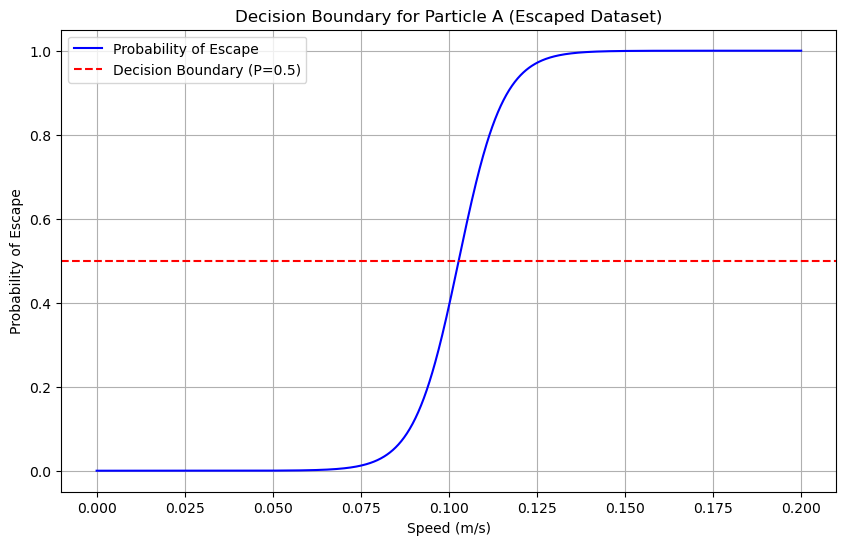

c:\Users\fiacc\miniconda3\envs\tesi_v2\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


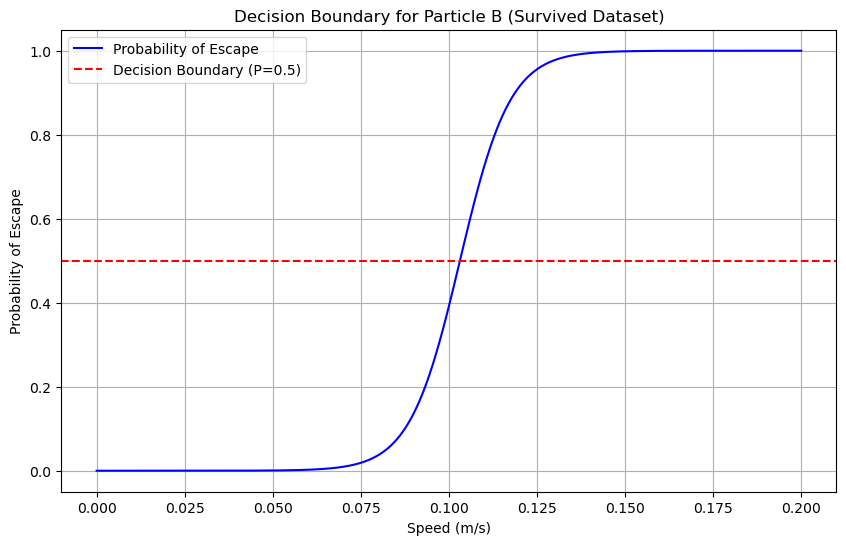

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

#### Linear Regression
def run_logistic_regression(X_train_scaled, y_train, X_test_scaled, y_test, name):
    """This function trains a logistic regression model given a training and test set and evaluates its performance.
    Inputs:
    - X_train_scaled: Scaled training features;
    - y_train: Training labels;
    - X_test_scaled: Scaled testing features;
    - y_test: Testing labels.
    - name: Name of the dataset/model for printing purposes.
    
    Outputs:
    - log_reg: Trained logistic regression model."""

    #Initialization and training of the logistic regression model
    log_reg = LogisticRegression(random_state=42) #Initialize the model
    log_reg.fit(X_train_scaled, y_train) #Train the model

    #Make predictions on the test set
    y_pred = log_reg.predict(X_test_scaled) #Predict the labels for the test set

    #Evaluate the model's performance
    print(classification_report(y_test, y_pred, target_names=['non-escape (0)', 'escape (1)'])) #Print classification report
    print("Confusion Matrix:") #Tells how many correct and incorrect predictions were made
    print(confusion_matrix(y_test, y_pred)) #Print confusion matrix

    #Computing the critical speed threshold, the boundary (P=50%) between escape and non-escape is when m*x_scaled + q = 0 -> x_scaled = -q/m
    m = log_reg.coef_[0][0]  #Coefficient for the feature
    q = log_reg.intercept_[0]  #Intercept
    v_crit_scaled = -q / m  #Critical speed in scaled units

    #Descaling the critical speed to original units (cm/s)
    v_crit_original = v_crit_scaled * scaler.scale_[0] + scaler.mean_[0]

    print(f'Angular coefficient (m): {m:.4f}, intercept (q): {q:.4f}')
    print(f'Critical speed threshold (scaled): {v_crit_scaled:.4f}')
    print(f'Critical speed threshold (original, cm/s): {v_crit_original:.5f}')
    print("--------------------------------------------------")

    return log_reg

#Execute logistic regression on escaped dataset (A)
model_escaped = run_logistic_regression(X_train_escaped_scaled, y_escaped_train, X_test_escaped_scaled, y_escaped_test, "Particle A (Escaped)")

#Execute logistic regression on survived dataset (B)
model_survived = run_logistic_regression(X_train_survived_scaled, y_survived_train, X_test_survived_scaled, y_survived_test, "Particle B (Survived)")

#Plot the decision boundary for both models
def plot_decision_boundary(log_reg, scaler, title):
    #Generate a range of speed values
    v_mag_range = np.linspace(0, 0.2, 1000).reshape(-1, 1)  #From 0 to 20 cm/s

    #Scale the speed values using the same scaler used for training
    v_mag_range_scaled = scaler.transform(v_mag_range)

    #Predict probabilities using the logistic regression model
    probabilities = log_reg.predict_proba(v_mag_range_scaled)[:, 1]  #Probability of class '1' (escape)

    #Plot the decision boundary
    plt.figure(figsize=(10, 6)) 
    plt.plot(v_mag_range, probabilities, label='Probability of Escape', color='blue')
    plt.axhline(0.5, color='red', linestyle='--', label ='Decision Boundary (P=0.5)')
    plt.xlabel('Speed (m/s)')
    plt.ylabel('Probability of Escape')
    plt.title(title)
    plt.legend()
    plt.grid()
    #save plot
    plt.savefig(f"../results/plots/2nd_dataset/{title.replace(' ', '_').lower()}.png", dpi=300)
    plt.show()

#Plot decision boundary for escaped model
plot_decision_boundary(model_escaped, scaler, 'Decision Boundary for Particle A (Escaped Dataset)')

#Plot decision boundary for survived model
plot_decision_boundary(model_survived, scaler, 'Decision Boundary for Particle B (Survived Dataset)')


We can see from the results above that the critical speed threshold found by the linear regression model is around 0.103 m/s for both test sets. The accuracy, precision, recall, and f1-score are also quite good, indicating that the linear regression model is effective for this classification task.

### Support Vector Machine (SVM)

Now we get to the SVM. Differently from the Logistic Regression, which acts in terms of probability (0\% -> 100\%), the SVM is a geometric model that tries to find the optimal hyperplane that separates the two classes. In our case, being a 1D problem, the hyperplane is just a point (threshold speed) that divides the two classes (escaped and not escaped particles). The SVM tries to maximize the margin between the two classes, which is defined as the distance between the hyperplane and the closest points from each class (support vectors). The key hyperparameters to tune in SVM are the kernel type (linear, polynomial, radial basis function, etc.), the regularization parameter C (which controls the trade-off between maximizing the margin and minimizing classification error), and gamma (which defines how far the influence of a single training example reaches).

Since we have a 1D proble with a grey zone in the middle, we will use a radial basis function (RBF) kernel to allow for non-linear decision boundaries. We will also perform hyperparameter tuning using grid search with cross-validation to find the best values for C and gamma. We will select a C value of 100 to have an hard margin.
Gamma will be tuned to find the best fit for the data distribution.

In [49]:
from sklearn.svm import SVC

def train_svm_find_treshold(X_train_scaled, y_train, X_test_scaled, y_test, scaler, name):
    """ 
    Inputs:
    - X_train_scaled: Scaled training features;
    - y_train: Training labels;
    - X_test_scaled: Scaled testing features;
    - y_test: Testing labels.
    - scaler: Scaler used for data preprocessing.
    - name: Name of the dataset/model for printing purposes.

    Outputs:
    - svm: Trained SVM model.
    """

    # Configure and Train SVM model
    # CHANGE 1: Added class_weight='balanced' to fix the boundary bias in the mixed zone
    # gamma='scale': let sklearn choose the best gamma based on data
    svm = SVC(kernel='rbf', C=1, gamma='scale', random_state=42, probability=True, class_weight='balanced')
    svm.fit(X_train_scaled, y_train)

    # Evaluate the model
    y_pred = svm.predict(X_test_scaled)
    print(f"SVM Classification Report for {name}:")
    # CHANGE 2: Updated labels to -1/1 consistent with previous steps
    print(classification_report(y_test, y_pred, target_names=['non-escape (-1)', 'escape (1)']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Search of the optimal threshold speed
    # Since there is no explicit formula for the decision boundary in SVM with RBF kernel, we will search for it numerically.
    # Generate 5000 points between min and max of scaled speed in the training set
    v_mag_range = np.linspace(X_train_scaled.min(), X_train_scaled.max(), 5000).reshape(-1, 1)

    # Predict the probabilities for these points
    probs = svm.predict_proba(v_mag_range)[:, 1]  # Probability of class '1' (escape)

    # Find the point where the probability is closest to 0.5
    idx = (np.abs(probs - 0.5)).argmin()
    v_crit_scaled = v_mag_range[idx][0]

    # Descale the critical speed to original units (m/s or cm/s depending on input)
    # Formula: x_real = x_scaled * std + mean
    v_crit_original = v_crit_scaled * scaler.scale_[0] + scaler.mean_[0]

    print(f'Critical speed threshold (scaled): {v_crit_scaled:.4f}')
    print(f'Critical speed threshold (original, m/s): {v_crit_original:.5f} m/s')
    print("--------------------------------------------------")

    return svm, v_crit_original

#Execute SVM on escaped dataset (A)
# Note: scaler is different from the logistic regression scaler and for each dataset
scaler_A = StandardScaler().fit(X_escaped_train)
svm_escaped, v_crit_A = train_svm_find_treshold(X_train_escaped_scaled, y_escaped_train, X_test_escaped_scaled, y_escaped_test, scaler_A, "Particle A (Escaped)")

#Execute SVM on survived dataset (B)
scaler_B = StandardScaler().fit(X_survived_train)
svm_survived, v_crit_B = train_svm_find_treshold(X_train_survived_scaled, y_survived_train, X_test_survived_scaled, y_survived_test, scaler_B, "Particle B (Survived)")


SVM Classification Report for Particle A (Escaped):
                 precision    recall  f1-score   support

non-escape (-1)       0.89      0.95      0.92       108
     escape (1)       0.94      0.86      0.90        92

       accuracy                           0.91       200
      macro avg       0.91      0.91      0.91       200
   weighted avg       0.91      0.91      0.91       200

Confusion Matrix:
[[103   5]
 [ 13  79]]
Critical speed threshold (scaled): 0.2782
Critical speed threshold (original, m/s): 0.10625 m/s
--------------------------------------------------
SVM Classification Report for Particle B (Survived):
                 precision    recall  f1-score   support

non-escape (-1)       0.85      0.91      0.88       109
     escape (1)       0.88      0.81      0.85        91

       accuracy                           0.86       200
      macro avg       0.87      0.86      0.86       200
   weighted avg       0.87      0.86      0.86       200

Confusion Matrix:

#### Rationale for Combined Analysis: Proving Gravitational Anisotropy
In an idealized Two-Body Problem with spherically symmetric bodies, the escape velocity is primarily a function of the radial distance ($v_{esc} \propto \sqrt{1/r}$). However, the Didymos-Dimorphos system is characterized by highly irregular shapes and a complex, non-axisymmetric gravitational potential. Consequently, the escape condition is expected to be also position-dependent, meaning that particles launching from different coordinates $(x, y, z)$ will encounter different energy barriers even if their initial speed is identical. In the previous separate analyses, we identified distinct critical velocity thresholds ($v_{crit}$) for Particle A and Particle B. In this section, we combine both datasets to visualize this discrepancy directly. By plotting the two populations side-by-side, we aim to demonstrate that the "escape threshold" is not a universal constant for the system, but shifts based on the launch location. This shift serves as empirical evidence that the local gravitational environment plays a non-negligible role in determining the fate of the ejecta, confirming that a global 1D model based solely on velocity magnitude $|v|$ is an approximation that depends on spatial context.

In [50]:
# #Add a column with an identifier which tells from which dataset the particle comes from
# df_escaped['Origin'] = 'Particle A (Escaped)'
# df_survived['Origin'] = 'Particle B (Survived)'

# #Unify the two datasets
# df_combined = pd.concat([df_escaped, df_survived], ignore_index=True)

# #Save the combined dataframe
# df_combined.to_csv("../data/processed/dataset_combined.csv", index=False)

# print("Combined dataset saved to ../data/processed/dataset_combined.csv")
# print("\nVerify class distribution in the combined dataset:")
# print(df_combined.groupby('Origin')['target'].value_counts())

1. Visualization of the "Gravitational Step"
    We will plot the two populations side-by-side to visually confirm the shift in escape thresholds.Hypothesis: If the system were spherically symmetric, the thresholds would align. A visible "step" between the two critical velocities will serve as empirical evidence of the non-uniform gravitational field.
2. The "Naive" 1D Model (Velocity Only)
    We will train a Machine Learning model on the combined dataset using only the velocity magnitude $|v|$ as a feature, deliberately ignoring the particle's origin.Expectation: We expect this model to underperform (lower accuracy/F1-score) specifically in the "interference region" between the two thresholds (approx. $10.2$ - $10.9$ cm/s). In this range, the same velocity leads to different outcomes depending on the hidden position variable, confusing the model.Goal: To demonstrate quantitatively that a pure 1D model cannot be generalized to the entire system.
3. The "Context-Aware" Model (Velocity + Position)
    We will train a final model adding the Origin (Position ID) as a feature.Expectation: By providing spatial context, the model should be able to learn two distinct decision boundaries, recovering near-perfect accuracy ($\sim 99\%$).Significance: This will prove that a Machine Learning approach can effectively map the local topology of the escape potential, adapting the escape criterion based on location.

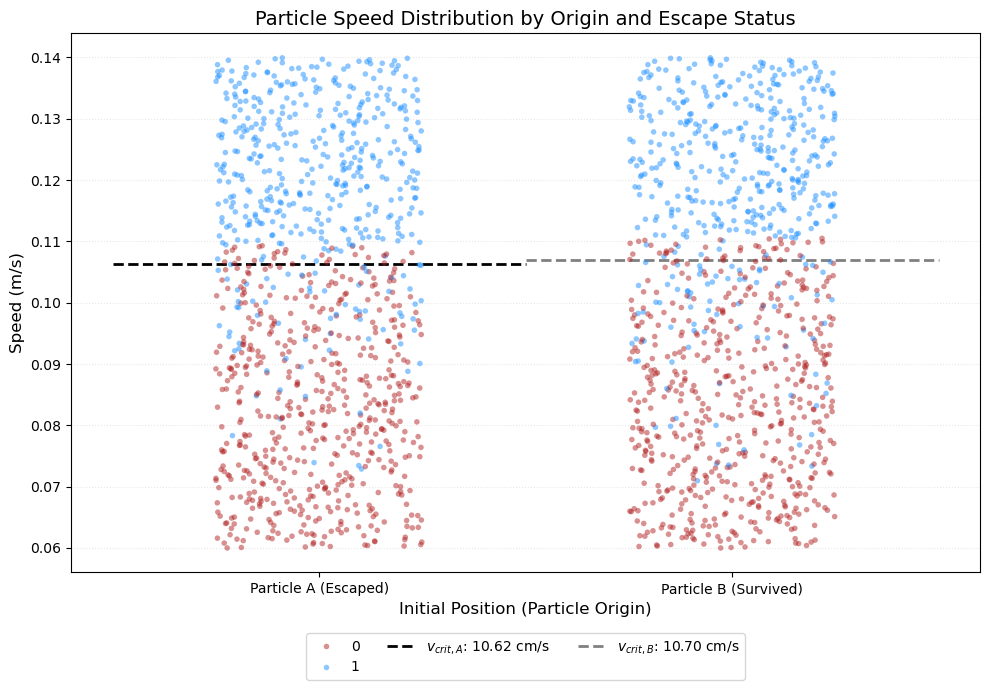

In [64]:
import seaborn as sns

#Load the combined dataset
df_combined = pd.read_csv("../data/processed/dataset_combined.csv")

#Plot Configuration
plt.figure(figsize=(10, 7))

#Strip Plot: shows each individual data point as a dot.
#hue='target' colors the points based on escape status
#jitter adds random noise to the x-axis position to prevent overlap
sns.stripplot(data=df_combined, x='Origin', y='v_mag', hue='target',
              palette={0: 'firebrick', 1: 'dodgerblue'},
              alpha=0.5, size=4, jitter=0.25)

#Add threshold lines for both particles based on previous SVM results
v_crit_A = 0.10625  #Threshold for Particle A (Escaped) in m/s
v_crit_B = 0.10697  #Threshold for Particle B (Survived) in m/s

#Plot horizontal lines for thresholds
plt.hlines(y=v_crit_A, xmin=-0.5, xmax=0.5, colors='black', linestyles='--',linewidth=2, label=f'$v_{{crit, A}}$: {v_crit_A*100:.2f} cm/s')
plt.hlines(y=v_crit_B, xmin=0.5, xmax=1.5, colors='gray', linestyles='--',linewidth=2, label=f'$v_{{crit, B}}$: {v_crit_B*100:.2f} cm/s')

#Labels, Title, Legend and Details
plt.title('Particle Speed Distribution by Origin and Escape Status', fontsize=14)
plt.xlabel('Initial Position (Particle Origin)', fontsize=12)
plt.ylabel('Speed (m/s)', fontsize=12)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=10)
plt.grid(axis='y', alpha=0.3, linestyle=':')

plt.tight_layout()
plt.savefig("../results/plots/2nd_dataset/SVM_threshold.png", dpi=300)
plt.show()

In [52]:
def train_naive_model():

    #Load combined dataset
    df_combined = pd.read_csv("../data/processed/dataset_combined.csv")

    #Setup 'Naive' model with only velocity magnitude as feature
    X = df_combined[['v_mag']]
    y = df_combined['target']

    #Split and scale the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Train Logistic Regression Model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train)

    #Evaluate the model
    y_pred = model.predict(X_test_scaled)
    print("Naive Model (Velocity Only) Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['non-escape (0)', 'escape (1)']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    #Compute critical speed threshold
    m = model.coef_[0][0]
    q = model.intercept_[0]
    v_crit_scaled = -q / m

    #Descaling
    v_crit_original = v_crit_scaled * scaler.scale_[0] + scaler.mean_[0]

    print(f'Critical speed threshold (original, m/s): {v_crit_original:.5f} m/s')
    return model, scaler, v_crit_original

naive_model, naive_scaler, naive_threshold = train_naive_model()



Naive Model (Velocity Only) Classification Report:
                precision    recall  f1-score   support

non-escape (0)       0.90      0.89      0.90       216
    escape (1)       0.87      0.89      0.88       184

      accuracy                           0.89       400
     macro avg       0.89      0.89      0.89       400
  weighted avg       0.89      0.89      0.89       400

Confusion Matrix:
[[192  24]
 [ 21 163]]
Critical speed threshold (original, m/s): 0.10312 m/s


In [53]:
def train_context_aware_model():

    #Load combined dataset
    df_combined = pd.read_csv("../data/processed/dataset_combined.csv")

    #Setup 'Context-Aware' model with velocity magnitude and origin as features
    df_features = pd.get_dummies(df_combined[['v_mag', 'Origin']], columns=['Origin'], drop_first=True)

    X = df_features.values
    y = df_combined['target']

    #Split and scale the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    #Scale on two features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Train Logistic Regression Model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train)

    #Evaluate the model
    y_pred = model.predict(X_test_scaled)
    print("Context-Aware Model (Velocity + Position) Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['non-escape (0)', 'escape (1)']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    #Coefficients analysis
    m1_vmag = model.coef_[0][0]  #weight for v_mag
    m2_origin = model.coef_[0][1]  #weight for position (Origin_B vs Origin_A)

    print("\n--- Model Analysis ---")
    print(f"Weight for Velocity Magnitude (m1): {m1_vmag:.4f} (determines steepness of decision boundary)")
    print(f"Weight for Position Origin (m2): {m2_origin:.4f} (shifts decision boundary based on origin)")

    return model, scaler

context_aware_model, context_aware_scaler = train_context_aware_model()

Context-Aware Model (Velocity + Position) Classification Report:
                precision    recall  f1-score   support

non-escape (0)       0.90      0.89      0.90       216
    escape (1)       0.88      0.89      0.88       184

      accuracy                           0.89       400
     macro avg       0.89      0.89      0.89       400
  weighted avg       0.89      0.89      0.89       400

Confusion Matrix:
[[193  23]
 [ 21 163]]

--- Model Analysis ---
Weight for Velocity Magnitude (m1): 3.5285 (determines steepness of decision boundary)
Weight for Position Origin (m2): 0.0262 (shifts decision boundary based on origin)


#### Interpretation of Results: The Dominance of Chaos
Comparing the Naive Model and the Context-Aware SVM reveals a significant finding: adding positional information does not significantly improve classification performance.While our visual analysis confirmed a "gravitational step" (a shift in escape threshold between Particle A and B), the Machine Learning models stalled at an accuracy of ~89-90%. The threshold shift ($\Delta v_{crit} \approx 0.0072$ cm/s) is not very deep and consistent so it could be confirming the gravitational field is non-uniform, or it could just be noise.
Chaos Dominates: The width of the chaotic transition region (the range of velocities where outcomes are probabilistic) is larger than the threshold shift. 
Conclusion: The "noise" introduced by chaotic dynamics effectively masks the "signal" provided by the position. Even with a non-linear model (SVM) and explicit positional features, the intrinsic unpredictability of the chaotic zone prevents perfect classification. The limit of $\sim 90\%$ accuracy represents the theoretical predictability limit for this specific simplified feature set.


#### Using SVMs instead of Linear Regressions
One last try can be done using SVMs instead of Linear Regression to see if it is capable to gain performance including the position in the analysis. We will confront a "naive" SVM which does not take into account position and a "Context Aware" SVM which takes into account position.

In [54]:
# Function to train and evaluate SVM

def train_evaluate_svm(X, y, name):

    #Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

    #Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Train SVM (weighted to handle class imbalance and C=1 for regularization)
    svm = SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced', random_state=42, probability=True)
    svm.fit(X_train_scaled, y_train)

    #Evaluate
    y_pred = svm.predict(X_test_scaled)
    print(f"SVM Classification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=['non-escape (-1)', 'escape (1)']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return svm.score(X_test_scaled, y_test)

# First Model: SVM on velocity only (Naive)
X_naive = df_combined[['v_mag']].values
y_naive = df_combined['target'].values
svm_naive= train_evaluate_svm(X_naive, y_naive, "Naive SVM (Velocity Only)")

# Second Model: SVM on velocity + position (Context-Aware)
df_context = pd.get_dummies(df_combined[['v_mag', 'Origin']], columns=['Origin'], drop_first=True)
X_context = df_context.values
y_context = df_combined['target'].values
svm_context = train_evaluate_svm(X_context, y_context, "Context-Aware SVM (Velocity + Position)")

# Compare the two SVM models on accuracy
print("\n--- SVM Model Comparison ---")
print(f"Naive SVM Accuracy: {svm_naive*100:.2f}%")
print(f"Context-Aware SVM Accuracy: {svm_context*100:.2f}%")

delta = svm_context - svm_naive
if abs(delta) < 0.01:
    print("Conclusion: Adding position information does not significantly improve SVM performance, indicating chaos dominates.")
else:
    print("Conclusion: Position information improves SVM performance, indicating some predictability from initial conditions.")

SVM Classification Report for Naive SVM (Velocity Only):
                 precision    recall  f1-score   support

non-escape (-1)       0.89      0.95      0.92       216
     escape (1)       0.94      0.86      0.90       184

       accuracy                           0.91       400
      macro avg       0.91      0.91      0.91       400
   weighted avg       0.91      0.91      0.91       400

Confusion Matrix:
[[205  11]
 [ 25 159]]
SVM Classification Report for Context-Aware SVM (Velocity + Position):
                 precision    recall  f1-score   support

non-escape (-1)       0.89      0.94      0.92       216
     escape (1)       0.92      0.87      0.90       184

       accuracy                           0.91       400
      macro avg       0.91      0.90      0.91       400
   weighted avg       0.91      0.91      0.91       400

Confusion Matrix:
[[203  13]
 [ 24 160]]

--- SVM Model Comparison ---
Naive SVM Accuracy: 91.00%
Context-Aware SVM Accuracy: 90.75%
Conclusi